**Copyright 2018 The TensorFlow Authors**.

Licensed under the Apache License, Version 2.0 (the "License").

# Generating Handwritten Digits with DCGAN

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

This tutorial demonstrates how to generate images of handwritten digits with **Deep Convolutional Generative Adversarial Networks** ([DCGAN](https://arxiv.org/pdf/1511.06434.pdf)). The code is written in [tf.keras](https://www.tensorflow.org/programmers_guide/keras) with [eager execution](https://www.tensorflow.org/programmers_guide/eager) enabled. 

>[Generating Handwritten Digits with DCGAN](#scrollTo=0TD5ZrvEMbhZ)

>>[What are GANs?](#scrollTo=2MbKJY38Puy9)

>>>[Import TensorFlow and enable eager execution](#scrollTo=e1_Y75QXJS6h)

>>>[Load the dataset](#scrollTo=iYn4MdZnKCey)

>>>[Use tf.data to create batches and shuffle the dataset](#scrollTo=PIGN6ouoQxt3)

>>[Create the models](#scrollTo=THY-sZMiQ4UV)

>>>[The Generator Model](#scrollTo=-tEyxE-GMC48)

>>>[The Discriminator model](#scrollTo=D0IKnaCtg6WE)

>>[Define the loss functions and the optimizer](#scrollTo=0FMYgY_mPfTi)

>>>[Generator loss](#scrollTo=Jd-3GCUEiKtv)

>>>[Discriminator loss](#scrollTo=PKY_iPSPNWoj)

>>[Set up GANs for Training](#scrollTo=Rw1fkAczTQYh)

>>[Train the GANs](#scrollTo=dZrd4CdjR-Fp)

>>[Generated images](#scrollTo=P4M_vIbUi7c0)

>>[Learn more about GANs](#scrollTo=k6qC-SbjK0yW)



## What are GANs?
GANs stands for **Generative Adversarial Networks** and they are a type of deep **generative** models. MIT [Intro to Deep Learning](http://introtodeeplearning.com/) lecture on **Deep Generative Models** has a great intro to generative models as well as GANs. ([video](https://youtu.be/JVb54xhEw6Y) | [slides](http://introtodeeplearning.com/materials/2018_6S191_Lecture4.pdf)). We have included more learning resources on these subjects in the "Learn more about GANs" section at the end of the tutorial.

Many deep learning models, for example using a CNN for classification, are based on optimization: finding the low value of the cost function. GANs are different because there are at least two players (or network models): a generator and a discriminator and each has its own cost. Training GANs is like a two-player game (**adversarial**) such as chess where each player plays against each other.

 **Deep Convolutional GAN** (DCGAN) is a type of GANs and in this tutorial we will use DCGAN to generate MNIST digits.

GANs can be used to generate new images that no one has seen before. The generator will generate fake images while the discriminator will classify whether the generated images are fake. The game will reach an ** equilibrium** when the generator makes data that looks identical to the training data and the discriminator can no longer tell the difference between the fake images (generated by the generator) and the real images (the training data). 

![alt text](https://github.com/margaretmz/tensorflow/blob/margaret-dcgan/tensorflow/contrib/eager/python/examples/generative_examples/gans_diagram.png?raw=1)

While the generator and discriminator compete against each other, the discriminator also teaches the generator . Over time the generator starts to produce images that resemble the training data that is fed into the discriminator, in this case the MNIST digits. Below is the output with images generated after training the generator and discriminator models for 150 epochs.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

Installation, Imports and prepare the datasets

In [1]:
# install imgeio in order to generate an animated gif showing the image generating process
!pip install imageio

    100% |████████████████████████████████| 3.3MB 5.5MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


### Import TensorFlow and enable eager execution

Note: you can only call tf.enable_eager_execution once. 
Restart runtime in colab and rerun the cells if you get an error as below:

*ValueError: tf.enable_eager_execution must be called at program startup.*

In [0]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

### Load the dataset

We are going to use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# We are normalizing the images to the range of [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

### Use tf.data to create batches and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

We will use tf.keras model subclassing to create the generator and discriminator. We will create layers in the __init__ method and set them as attributes of the class instance. And then define the forward pass in the **call **method.

### The Generator Model

The **generator **is responsible for **creating convincing images that are good enough to fool the discriminator**. 

Here is the network architecture for the generator:
 * It consists of Conv2DTranspose (Upsampling) layers. We start with a fully connected layer and **upsample** the image 2 times in order to reach the desired image size as mnist image size of (28, 28, 1). We increase the width and height, and reduce the depth as we move through the layers in the network.
 * We use **leaky relu** activation except for the **last layer** which uses **tanh** activation.

In [0]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = tf.keras.layers.Dense(7*7*64, use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    
    self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    # Layer shape is now 7x7x64    
    
    self.batchnorm2 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    # Layer shape is now 14x14x32
    
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
   
    self.conv3 = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    # Layer shape is now 28x28x1

  def call(self, x, training=True):
    x = self.fc1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)

    x = tf.reshape(x, shape=(-1, 7, 7, 64))

    x = self.conv1(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2(x)
    x = self.batchnorm3(x, training=training)
    x = tf.nn.relu(x)

    x = tf.nn.tanh(self.conv3(x))  
    return x

### The Discriminator model

The **discriminator** is responsible for classifying the fake images from the real images. It's similar to a regular CNN image classifier.
  * **Input **to the discriminator:  images generated by the generator and the real MNIST images. 
  * **Output** from the discriminator: classify these images into fake (generated) and real (MNIST images).


In [0]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    x = tf.nn.leaky_relu(self.conv1(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv2(x))
    x = self.dropout(x, training=training)
    x = self.flatten(x)
    x = self.fc1(x)
    return x

In [0]:
generator = Generator()
discriminator = Discriminator()


This model takes about ~30 seconds per epoch to train on a single Tesla K80 on Colab, as of July 2018. Eager execution can sometimes be slower than executing the equivalent graph due to overheads of interpreting Python code. By using [tf.contrib.eager.defun](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/defun) to create graph functions, we get 10 secs/epoch performance boost. This way we get the best of both eager execution (easier for debugging) and graph mode (better performance).

In [0]:
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

## Define the loss functions and the optimizer

Let's define the loss functions and the optimizers for the generator and the discriminator.


### Generator loss
The generator loss is a sigmoid cross entropy loss of the **generated images** and an **array of ones**, since the generator is trying to generate fake images that resemble the real images.

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

### Discriminator loss

The discriminator loss function takes 2 inputs; **real images, generated images**.

Here is how to calculate the discriminator loss:
1. Calculate real_loss which is a sigmoid cross entropy loss of the **real images** and an **array of ones (since these are the real images)**
2. Calculate generated_loss which is a sigmoid cross entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**
3. Calculate the total_loss as **the sum of real_loss and generated_loss**

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

**Checkpoints (Object-based saving)**

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Set up GANs for Training



Now it's time to put together the generator and discriminator to set up the Generative Adversarial Networks, as you see in the diagam at the beginning of the tutorial.

**Define training parameters**

In [0]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

**Define training method**

We start by iterating over the dataset. The generator is given **noise as an input** which is passed through the generator model and output a image looking like a handwritten digit. The discriminator is given the **real MNIST images as well as the generated images (from the generator)**.

Next, we calculate the generator and the discriminator loss. Then we calculate the gradients of loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.

In [0]:
def train(dataset, epochs, noise_dim):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      # generating noise from a uniform distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    if epoch % 1 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

**Generate and save images**



In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the GANs
We will call the train() method defined above to train the generator and discriminator simultaneously. Note training GANs can be tricky and it's important that the generator and discriminator are not overpowering each other so that the generator is able able to generate while the discriminator is able to discriminate.

At the beginning of the training, the images generated look more like the input random noise. As the training goes on, you can see the digits generated are looking better. After 150 epochs they look very much like the MNIST digits.

In [0]:
%%time
train(train_dataset, EPOCHS, noise_dim)

**Restore the latest checkpoint**

In [19]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generated images 



After training, its time to generate some images! 
The last step is to plot the generated images and **voila!**


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

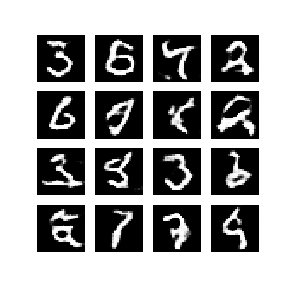

In [21]:
display_image(EPOCHS)

**Generate a GIF of all the saved images**

We will use imageio to create an animated gif using all the images saved during training.

In [22]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

Display the animated gif with all the mages generated during the training of GANs.

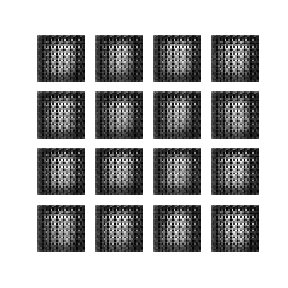

In [23]:
display.Image(filename="dcgan.gif.png")

**Download animated gif**

Uncomment the code below to download an animated gif from Colab:

In [0]:
#from google.colab import files
#files.download('dcgan.gif')

## Learn more about GANs


Now that you have learned how to generate new images (MNIST digits) with deep convolutional GANs, here are a few suggested next steps:

* Tweak the code in this tutorial to see different effects.
* Try out this tutorial on a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset ([available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset/home)).
* Learn more about GANs - see below the learning resources.

** Deep Generative Models and GANs**

GANs is a type of deep generative models and DCGAN is just one type of the GANs. 
* MIT [Intro to Deep Learning](http://introtodeeplearning.com/) lecture on **Deep Generative Models** has a great intro to generative models as well as GANs. ([video](https://youtu.be/JVb54xhEw6Y) | [slides](http://introtodeeplearning.com/materials/2018_6S191_Lecture4.pdf))
* Stanford CS 231N lecture 12 **Generative Models** on PixelRNN/CNN, 
VAE and GANs. ([slides](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture12.pdf))
* This Github has a good [collection](https://github.com/wiseodd/generative-models) of GANs and generative models. 

**GANs research papers:**
* The original [GANs](https://arxiv.org/abs/1406.2661) paper.
* DCGAN paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

**GANs tutorials**

* [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160) - a bit dated but great explanation on what/why generative models, what are GANs and how they compare to other generative models.
* Here is a site with excellent tutorials on GANs by **Computer Vision and Pattern Recognition** - [CVPR 2018 Tutorial on GANs](https://sites.google.com/view/cvpr2018tutorialongans/).
